In [1]:
library(tidyverse)
library(tm)
library(Matrix)
library(glmnet)
library(ROCR)
library(ggplot2)


Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Loading required package: NLP

Attaching package: ‘NLP’

The following object is masked from ‘package:ggplot2’:

    annotate


Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-10

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



In [3]:
# read business and world articles into one data frame
bus <- read.csv('business.tsv', sep='\t')
world <- read.csv('world.tsv', sep='\t')
comb <- rbind(bus, world)
head(comb)

section,url,date,snippet
business,https://www.nytimes.com/2017/07/10/business/dealbook/class-action-lawsuits-finance-banks.html,2017-07-10T17:58:45+0000,The Consumer Financial Protection Bureau is adopting a rule that would block banks and credit card companies from forcing customers into arbitration....
business,https://www.nytimes.com/2017/07/10/business/dealbook/digital-privacy-supreme-court.html,2017-07-10T17:41:09+0000,Two cases — one involving cell site location and the other emails — may determine how digital information fits under Fourth Amendment protections....
business,https://www.nytimes.com/2017/07/10/business/energy-environment/siemens-russia-crimea-turbines.html,2017-07-10T16:58:05+0000,The German engineering company threatened legal action after it said a Russian firm broke promises not to ship power generation equipment to annexed territory....
business,https://www.nytimes.com/2017/07/10/business/dealbook/abercrombie-fitch-ends-talks-to-sell-itself.html,2017-07-10T13:39:37+0000,The retailer said it would instead focus on executing its business plan as a stand-alone company....
business,https://www.nytimes.com/2017/07/10/business/dealbook/morning-agenda-att-time-warner-justice-department-trump.html,2017-07-10T10:01:28+0000,"The Justice Department’s review of the merger is in its eighth month, but unknowns still exist, including whether the White House will try to stymie it...."
business,https://www.nytimes.com/2017/07/10/business/dealbook/wanda-sunac-hotels-china.html,2017-07-10T06:05:43+0000,"The Chinese conglomerate said it would sell $9.3 billion in hotels and tourism projects, and would use the cash to pay off loans...."


In [4]:
snipps <- comb %>%
select(snippet)

head(snipps)


snippet
The Consumer Financial Protection Bureau is adopting a rule that would block banks and credit card companies from forcing customers into arbitration....
Two cases — one involving cell site location and the other emails — may determine how digital information fits under Fourth Amendment protections....
The German engineering company threatened legal action after it said a Russian firm broke promises not to ship power generation equipment to annexed territory....
The retailer said it would instead focus on executing its business plan as a stand-alone company....
"The Justice Department’s review of the merger is in its eighth month, but unknowns still exist, including whether the White House will try to stymie it...."
"The Chinese conglomerate said it would sell $9.3 billion in hotels and tourism projects, and would use the cash to pay off loans...."


In [5]:
# create a Corpus from the article snippets
doc_vec <- snipps$snippet
head(doc_vec)


[1] The Consumer Financial Protection Bureau is adopting a rule that would block banks and credit card companies from forcing customers into arbitration....          
[2] Two cases — one involving cell site location and the other emails — may determine how digital information fits under Fourth Amendment protections....             
[3] The German engineering company threatened legal action after it said a Russian firm broke promises not to ship power generation equipment to annexed territory....
[4] The retailer said it would instead focus on executing its business plan as a stand-alone company....                                                              
[5] The Justice Department’s review of the merger is in its eighth month, but unknowns still exist, including whether the White House will try to stymie it....       
[6] The Chinese conglomerate said it would sell $9.3 billion in hotels and tourism projects, and would use the cash to pay off loans....                              
1968 Levels: “Fair and Balanced,” the motto that has long been a rallying cry for Fox News fans, has been replaced by “Most Watched, Most Trusted.”... ...

In [6]:
docs <- VCorpus(VectorSource(doc_vec))
docs


<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 2009

In [7]:
# remove punctuation and numbers
new_docs <- tm_map(docs, removePunctuation)
new_docs <- tm_map(new_docs, removeNumbers)
# create a DocumentTermMatrix from the snippet Corpus
dtm <- DocumentTermMatrix(new_docs)
# convert the DocumentTermMatrix to a sparseMatrix, required by cv.glmnet
# helper function
dtm_to_sparse <- function(dtm) {
 sparseMatrix(i=dtm$i, j=dtm$j, x=dtm$v, dims=c(dtm$nrow, dtm$ncol), dimnames=dtm$dimnames)
}


In [8]:
sp <- dtm_to_sparse(dtm)
sp

   [[ suppressing 32 column names ‘abandon’, ‘abandoned’, ‘abandonment’ ... ]]


2009 x 8401 sparse Matrix of class "dgCMatrix"
                                                                           
1    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
2    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
3    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
4    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
5    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
6    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
7    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
8    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
9    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
10   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
11   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
12   . . . . . . . . . . . . . . . . . . 

In [11]:
# create a train / test split
sample<-sample.int(n = nrow(sp), size = floor(.75 * nrow(sp)), replace = F)
train <- sp[sample, ]
test <- sp[-sample, ]
train_response <- comb[sample, ]
test_response <- comb[-sample, ]


In [12]:
train_response$section

[1] world    business world    world    world    business world    business
   [9] world    world    business business business business world    business
  [17] business world    business world    business world    business world   
  [25] business business world    world    business world    world    world   
  [33] world    business business business business business business business
  [41] business business world    business business world    world    business
  [49] business business business business world    business world    world   
  [57] world    business world    business business world    business world   
  [65] business world    business business world    business business world   
  [73] world    world    world    world    world    world    business business
  [81] world    world    business business business business world    business
  [89] business business world    business business world    world    business
  [97] business world    business world    world    world    world    business
 [105] world    business business world    business world    business business
 [113] world    world    world    world    world    world    business world   
 [121] world    world    business business world    world    world    world   
 [129] business business world    business business business business world   
 [137] business world    world    world    world    world    world    business
 [145] world    world    business world    world    world    business business
 [153] business business business business world    business business world   
 [161] world    world    world    business world    world    world    business
 [169] business world    business world    business business business business
 [177] world    world    business business world    business business world   
 [185] business business world    world    world    world    business world   
 [193] world    world    business business world    business world    world   
 [201] business business world    world    business world    world    business
 [209] business business world    world    world    world    business business
 [217] world    world    world    world    world    business business business
 [225] world    business business world    world    world    business business
 [233] world    business business world    business world    world    business
 [241] business world    business world    business business business world   
 [249] world    business business world    world    world    world    business
 [257] world    business business business business business business world   
 [265] business world    world    world    world    business world    business
 [273] world    world    world    world    business business world    world   
 [281] world    business world    business business world    world    business
 [289] business business business business world    world    business world   
 [297] world    business business world    business world    business business
 [305] business world    world    business world    world    world    business
 [313] business world    world    world    business world    world    business
 [321] business business business world    business business business world   
 [329] business business world    world    business business business world   
 [337] world    business world    world    business business business world   
 [345] world    world    world    business business world    world    business
 [353] business world    business business world    business world    world   
 [361] business world    world    business business world    world    business
 [369] world    business business world    business world    business business
 [377] world    world    business business world    world    business world   
 [385] world    world    world    world    business business world    world   
 [393] business world    world    world    world    business business world   
 [401] business world    business world    world    w

In [13]:
# cross-validate logistic regression with cv.glmnet, measuring auc
model <- cv.glmnet(train, train_response$section, family='binomial',type.measure = 'auc')

In [24]:
model

$lambda
 [1] 0.095022850 0.090703915 0.086581282 0.082646029 0.078889640 0.075303984
 [7] 0.071881302 0.068614186 0.065495565 0.062518690 0.059677119 0.056964702
[13] 0.054375569 0.051904115 0.049544993 0.047293097 0.045143552 0.043091708
[19] 0.041133124 0.039263560 0.037478970 0.035775493 0.034149442 0.032597297
[25] 0.031115700 0.029701443 0.028351467 0.027062849 0.025832800 0.024658660
[31] 0.023537886 0.022468052 0.021446845 0.020472053 0.019541566 0.018653372
[37] 0.017805547 0.016996258 0.016223752 0.015486357 0.014782478 0.014110592
[43] 0.013469244 0.012857046 0.012272673 0.011714861 0.011182403 0.010674145
[49] 0.010188989 0.009725884 0.009283827 0.008861863 0.008459077 0.008074599
[55] 0.007707596 0.007357274 0.007022875 0.006703674 0.006398982 0.006108138
[61] 0.005830514 0.005565508 0.005312547 0.005071084 0.004840595 0.004620583
[67] 0.004410570 0.004210103 0.004018747 0.003836089 0.003661733 0.003495301
[73] 0.003336434 0.003184788 0.003040035 0.002901861 0.002769967 0.0

In [14]:
# evaluate performance for the best-fit model
#, type='class'
labels <- predict(model,newx=test, s="lambda.min")
head(labels)

pred <- prediction(labels, test_response$section, label.ordering=c('business','world'))

,1
8,-1.55221675
13,0.05304968
14,0.61748162
20,-2.05559313
21,0.36937806
41,-1.40797008


In [15]:
pred

An object of class "prediction"
Slot "predictions":
[[1]]
  [1] -1.552216747  0.053049685  0.617481618 -2.055593127  0.369378057
  [6] -1.407970076  0.009094390 -0.402138701  0.586054285  0.334568801
 [11] -1.089593015 -0.552279849 -3.830689288 -0.062867857  0.369378057
 [16] -0.477362729 -2.734137666  0.576951924 -2.898425895 -0.196985151
 [21] -1.850729909 -3.498891517 -1.136613992 -1.710738031 -0.192997511
 [26] -0.272639632 -2.044835330 -1.800799839  0.802626939 -1.756352201
 [31] -0.129037530  1.497505471  0.547807349 -1.926170024 -1.213233126
 [36]  0.220999397 -0.377283468 -0.611585824 -1.384565346 -2.978861869
 [41]  0.509158492  0.369378057 -0.775790636 -1.972498305 -2.530644370
 [46] -0.951227188 -1.526283607 -1.552216747 -0.827262100 -1.128245547
 [51] -0.872826075 -0.336328706  0.369378057 -0.857588921 -0.790317448
 [56] -0.027288125 -0.642103074 -0.332195607 -2.616833062 -3.418549948
 [61] -7.213651048  0.508560957  1.987949422 -2.221018998 -0.149616792
 [66]  0.669916755 

In [16]:
m<-performance(pred, measure='tpr', x.measure='fpr')
#m<-performance(pred, measure='acc')
m

An object of class "performance"
Slot "x.name":
[1] "False positive rate"

Slot "y.name":
[1] "True positive rate"

Slot "alpha.name":
[1] "Cutoff"

Slot "x.values":
[[1]]
  [1] 0.000000000 0.000000000 0.000000000 0.000000000 0.000000000 0.000000000
  [7] 0.000000000 0.000000000 0.000000000 0.000000000 0.000000000 0.000000000
 [13] 0.000000000 0.000000000 0.000000000 0.000000000 0.000000000 0.000000000
 [19] 0.000000000 0.000000000 0.000000000 0.000000000 0.003816794 0.003816794
 [25] 0.003816794 0.007633588 0.007633588 0.007633588 0.007633588 0.007633588
 [31] 0.007633588 0.007633588 0.007633588 0.007633588 0.007633588 0.007633588
 [37] 0.007633588 0.007633588 0.007633588 0.007633588 0.007633588 0.007633588
 [43] 0.007633588 0.007633588 0.007633588 0.007633588 0.007633588 0.007633588
 [49] 0.007633588 0.007633588 0.011450382 0.011450382 0.011450382 0.011450382
 [55] 0.011450382 0.011450382 0.011450382 0.011450382 0.011450382 0.011450382
 [61] 0.011450382 0.011450382 0.011450382 0.0114

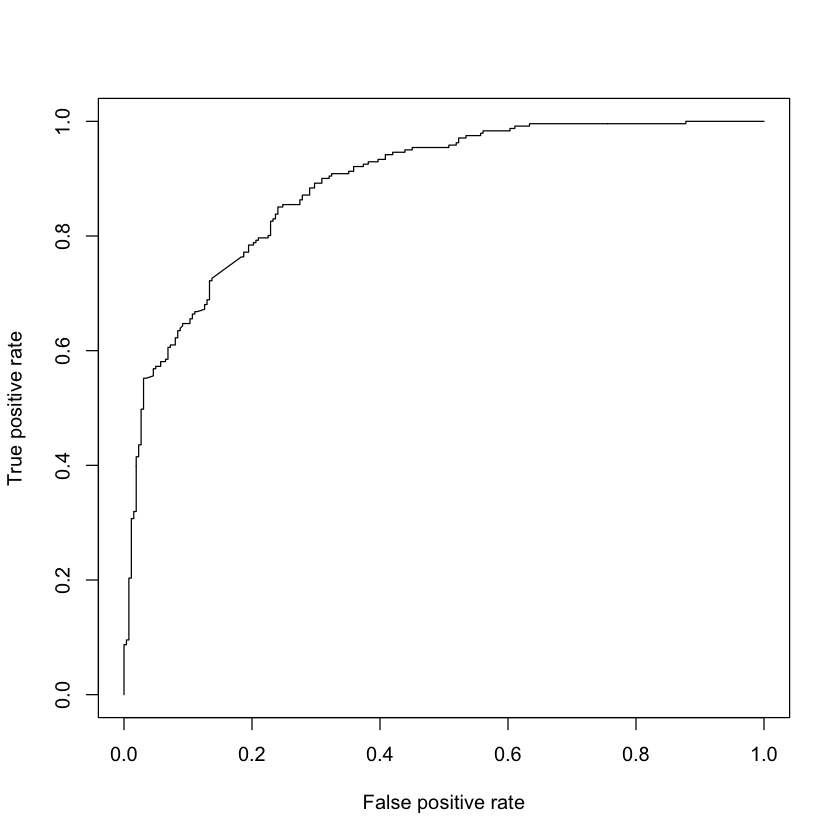

In [17]:
plot(m)

In [22]:
# plot ROC curve and output accuracy and AUC
#.831 accuracy

# extract coefficients for words with non-zero weight
# helper function
get_informative_words <- function(crossval) {
  coefs <- coef(crossval, s="lambda.min")
  coefs <- as.data.frame(as.matrix(coefs))
  names(coefs) <- "weight"
  coefs$word <- row.names(coefs)
  row.names(coefs) <- NULL
  subset(coefs, weight != 0)
}

words <- get_informative_words(model)
# show weights on words with top 10 weights for business
ranked <- words %>% 
arrange(weight) %>%
head(10)

In [23]:
ranked

weight,word
-1.921595,following
-1.762206,companies
-1.560918,network
-1.517225,arrests
-1.505992,company
-1.490456,technology
-1.463455,executives
-1.448300,flights
-1.435126,fox
-1.423301,financial


In [180]:
# show weights on words with top 10 weights for world
neg_ranked <- words %>% 
arrange(-weight)
neg_ranked[1:10,]

weight,word
2.044679,worry
1.959248,minister
1.827547,australia
1.630157,iran
1.560013,ndtv
1.526325,party
1.370590,london
1.316824,war
1.315161,corpses
1.255786,residents
